In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


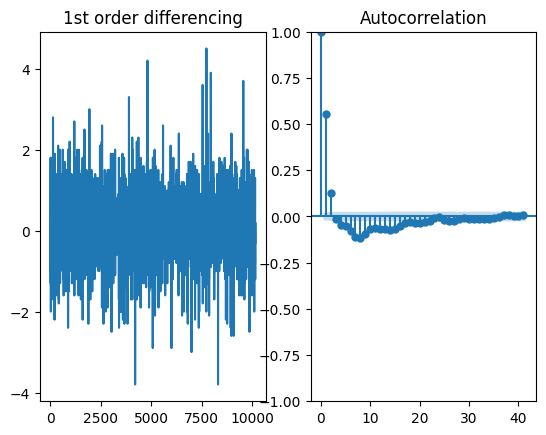

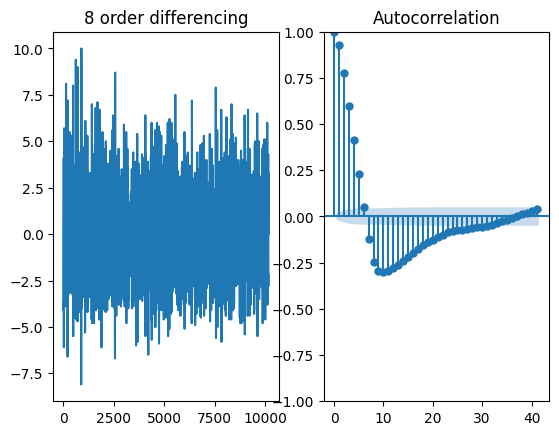

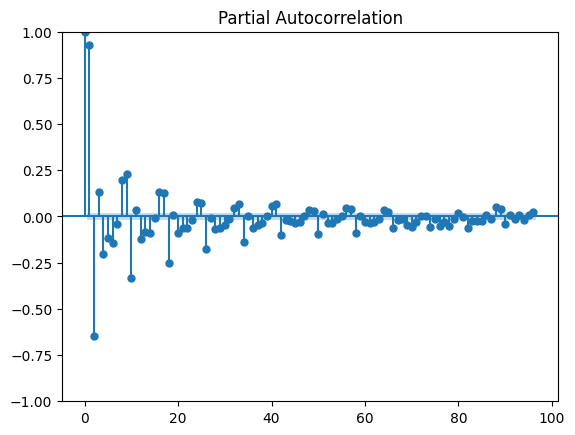

p-value original 1st: 7.294737315993314e-08
ADF Statistic 1st: -6.157850
Critical Values 1st:
	1%: -3.431
	5%: -2.862
	10%: -2.567


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpghmlmcsx/cbpauahi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpghmlmcsx/z1q1l3wk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4132', 'data', 'file=/tmp/tmpghmlmcsx/cbpauahi.json', 'init=/tmp/tmpghmlmcsx/z1q1l3wk.json', 'output', 'file=/tmp/tmpghmlmcsx/prophet_modelkgp641i1/prophet_model-20231213152547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:25:49 - cmdst

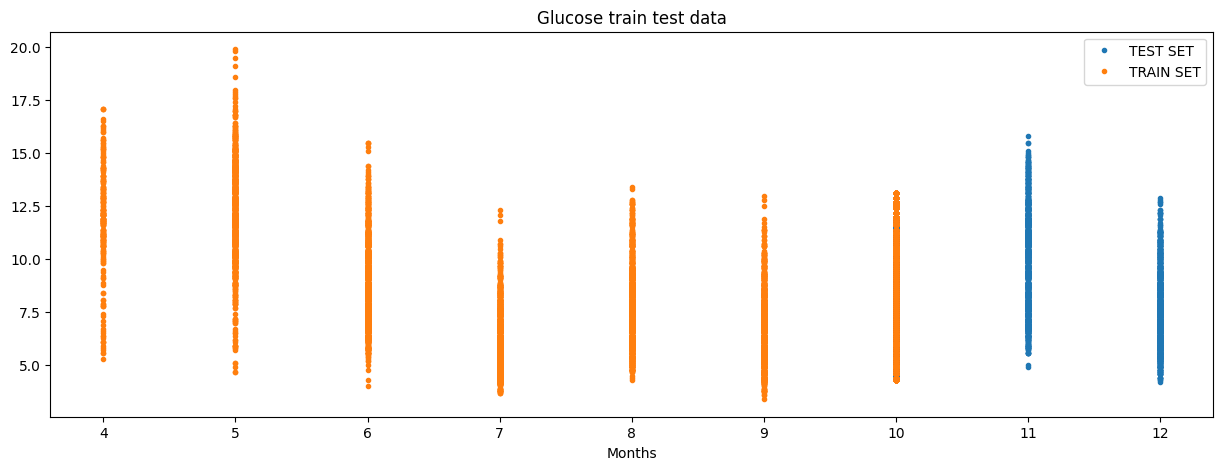

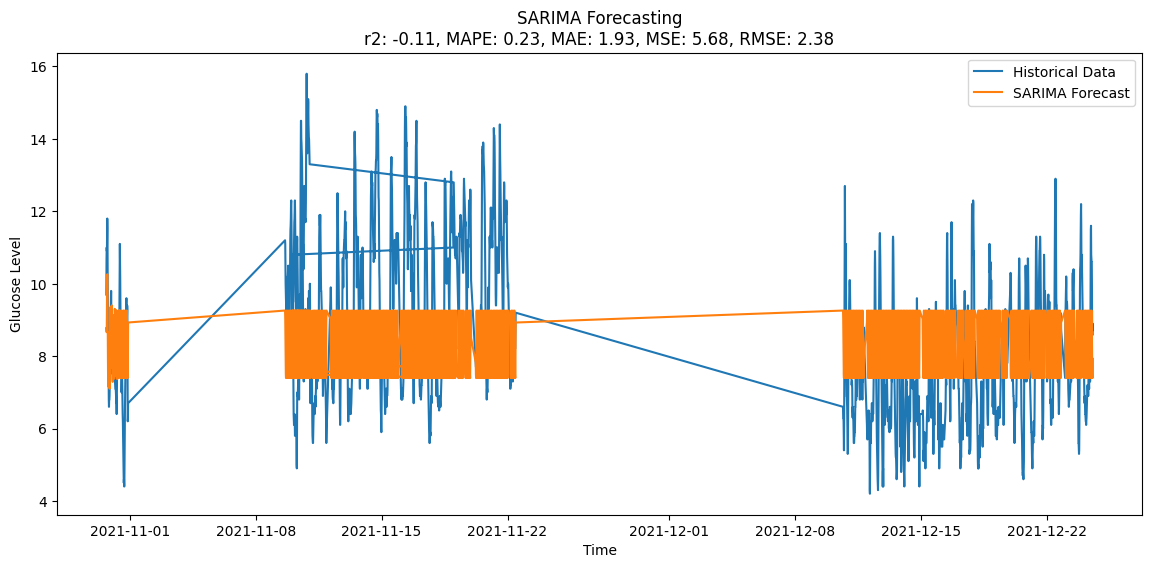

<Figure size 1400x600 with 0 Axes>

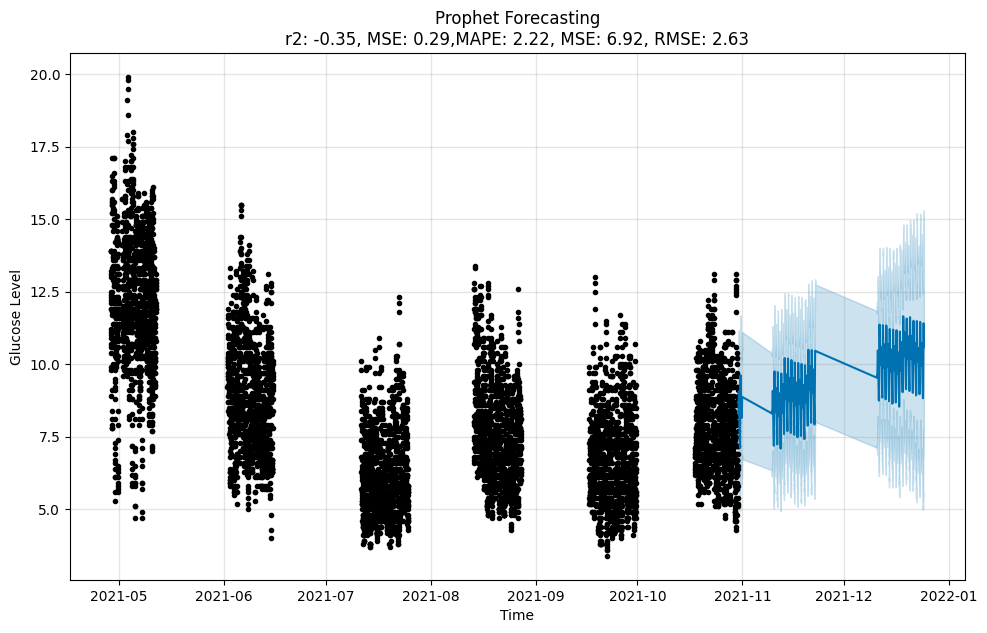

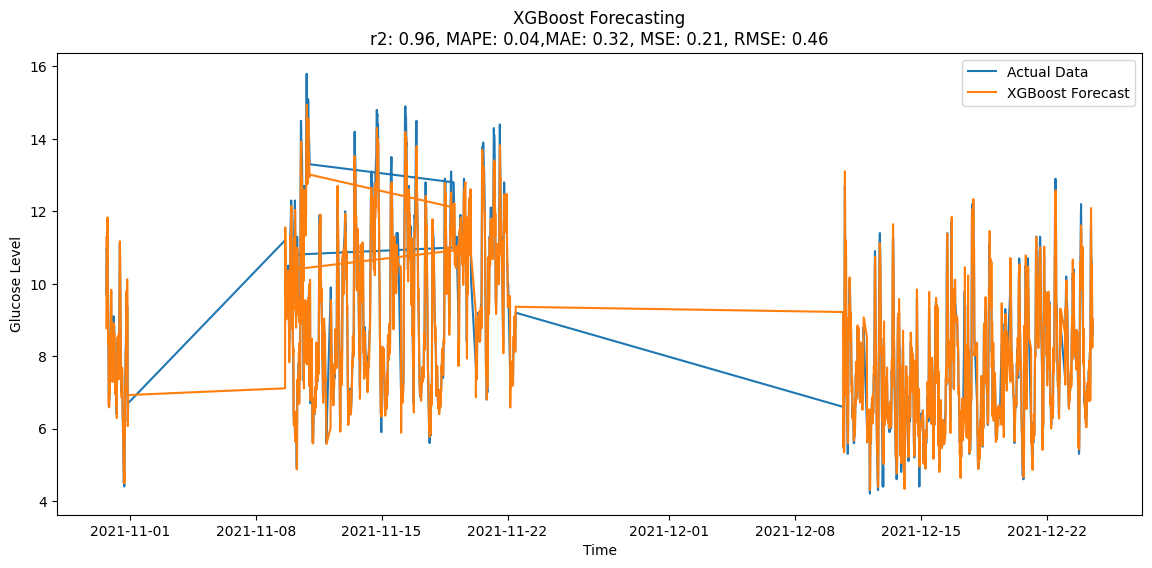

Months  Days_of_week  Hours  Glucose_Lag_1  Glucose_Lag_2  Glucose_Lag_3
0       4             2     13           14.1           14.8           15.0
1       4             2     14           13.9           14.1           14.8
2       4             2     14           13.9           13.9           14.1
3       4             2     14           13.0           13.9           13.9
4       4             2     14           12.3           13.0           13.9

In [13]:

df=pd.read_csv('/content/cgm5.csv')
# Load data from CSV file


# Ensure 'Time' column is in datetime format
df['Time'] = pd.to_datetime(df['Time'])

#df['Years'] = df['Time'].dt.year
df['Months'] = df['Time'].dt.month
#df['time'] = df['Time'].dt.time
df['Days_of_week'] = df['Time'].dt.dayofweek
df['Hours'] = df['Time'].dt.hour
#df['Minutes'] = df['Time'].dt.minute

# Feature engineering: Create lag features for XGBoost

for i in range(1, 4):  # Create lag features for the last 3 time points
  df[f'Glucose_Lag_{i}'] = df['Glucose'].shift(i)


# Feature engineering: Create ACF and PACF graphs features for Arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
#plot_acf(df['Glucose'])

f=plt.figure()
ax1=f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(df['Glucose'].diff())

ax2=f.add_subplot(122)
ax2.set_title('acf 1st order')
plot_acf(df['Glucose'].diff().dropna(),ax=ax2)
plt.show()

#f=plt.figure()
#ax1=f.add_subplot(121)
#ax1.set_title('2nd order differencing')
#ax1.plot(df['Glucose'].diff().diff())

f=plt.figure()
ax1=f.add_subplot(121)
ax1.set_title('8 order differencing')
ax1.plot(df['Glucose'].diff(8))

plot_pacf(df['Glucose'].diff(8).dropna(),lags=96)
ax2=f.add_subplot(122)
ax2.set_title('acf 2nd Order')
plot_acf(df['Glucose'].diff(8).dropna(),ax=ax2)
plt.show()

# adfuller
result= adfuller(df['Glucose'].dropna())
print('p-value original 1st:', result[1])
print('ADF Statistic 1st: %f' % result[0])

print('Critical Values 1st:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


#result= adfuller(df['Glucose'].diff().diff().dropna())
#print('p-value:', result[1])

# Drop NaN values resulting from lag features
df = df.dropna()

#remove outliers from our data set
df =df[(df['Glucose'] > 3.5 ) | (df['Glucose'] <= 17.5)]

# Split data into train and test sets
train_size = int(len(df) * 0.75)
train, test = df[0:train_size], df[train_size:]

#removing index from train test dataset
test=test.reset_index(drop=True)
train=train.reset_index(drop=True)

#test=test.set_index('Hours')
#train=train.set_index('Hours')

#code to plot train test dataset

data_test1=test
data_test1=data_test1.set_index('Months')
#data_test1=data_test1.set_index('Hours')
data_test1=data_test1.rename(columns={'Glucose': 'TEST SET'})

data_train1=train
data_train1=data_train1.set_index('Months')
#data_train1=data_train1.set_index('Hours')
data_train1=data_train1.rename(columns={'Glucose': 'TRAIN SET'})

data_test1=data_test1.drop(['Glucose_Lag_1','Glucose_Lag_2','Glucose_Lag_3','Time','Days_of_week','Hours'],axis=1)
data_train1=data_train1.drop(['Glucose_Lag_1','Glucose_Lag_2','Glucose_Lag_3','Time','Days_of_week','Hours'],axis=1)
color=['r', 'b', 'g', 'k', 'm']

data_test1.join(data_train1, how='outer').plot(figsize=(15,5), title='Glucose train test data', style='.')



# SARIMA model
sarima_model = SARIMAX(train['Glucose'], order=(8, 0,1), seasonal_order=(0,1,0,8))  # p=1, d=1 and q=2 (as two values are away from threshold )
sarima_result = sarima_model.fit()

# Prophet model
prophet_model = Prophet()
prophet_data = train.rename(columns={'Time': 'ds', 'Glucose': 'y'})
prophet_model.fit(prophet_data)

# XGBoost model
xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

X_train, y_train = train.drop(['Time','Glucose'], axis=1), train['Glucose']
X_test, y_test = test.drop(['Time','Glucose'], axis=1), test['Glucose']
xgb_model.fit(X_train, y_train)

# Forecasting with ARIMA
sarima_forecast = sarima_result.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calculate ARIMA errors
sarima_r2 = r2_score(test['Glucose'], sarima_forecast)
sarima_mape = mean_absolute_percentage_error(test['Glucose'], sarima_forecast)
sarima_mae = mean_absolute_error(test['Glucose'], sarima_forecast)
sarima_mse = mean_squared_error(test['Glucose'], sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)

# Plot SARIMA results
plt.figure(figsize=(14, 6))
plt.plot(test['Time'], test['Glucose'], label='Historical Data')
plt.plot(test['Time'], sarima_forecast, label='SARIMA Forecast', linestyle='solid')
plt.title('SARIMA Forecasting\nr2: {:.2f}, MAPE: {:.2f}, MAE: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}'.format(sarima_r2,sarima_mape,sarima_mae, sarima_mse, sarima_rmse))
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()

# Forecasting with Prophet
future_dates_prophet = pd.DataFrame({'ds': test['Time']})
prophet_forecast = prophet_model.predict(future_dates_prophet)
#r2_score, mean_absolute_percentage_error

# Calculate Prophet errors
prophet_r2 = r2_score(test['Glucose'], prophet_forecast['yhat'])
prophet_mape = mean_absolute_percentage_error(test['Glucose'], prophet_forecast['yhat'])
prophet_mae = mean_absolute_error(test['Glucose'], prophet_forecast['yhat'])
prophet_mse = mean_squared_error(test['Glucose'], prophet_forecast['yhat'])
prophet_rmse = np.sqrt(prophet_mse)

# Plot Prophet results
plt.figure(figsize=(14, 6))
prophet_model.plot(prophet_forecast, xlabel='Time', ylabel='Glucose Level')
plt.title('Prophet Forecasting\nr2: {:.2f}, MSE: {:.2f},MAPE: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}'.format(prophet_r2, prophet_mape, prophet_mae, prophet_mse, prophet_rmse))
plt.show()

# Forecasting with XGBoost
xgb_forecast = xgb_model.predict(X_test)

# Calculate XGBoost errors
xgb_r2 = r2_score(y_test, xgb_forecast)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_forecast)
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
xgb_mse = mean_squared_error(y_test, xgb_forecast)
xgb_rmse = np.sqrt(xgb_mse)

# Plot XGBoost results
plt.figure(figsize=(14, 6))
plt.plot(test['Time'], test['Glucose'], label='Actual Data')
plt.plot(test['Time'], xgb_forecast, label='XGBoost Forecast', linestyle='solid')
plt.title('XGBoost Forecasting\nr2: {:.2f}, MAPE: {:.2f},MAE: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}'.format(xgb_r2, xgb_mape, xgb_mae, xgb_mse, xgb_rmse))
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()

X_train.head()

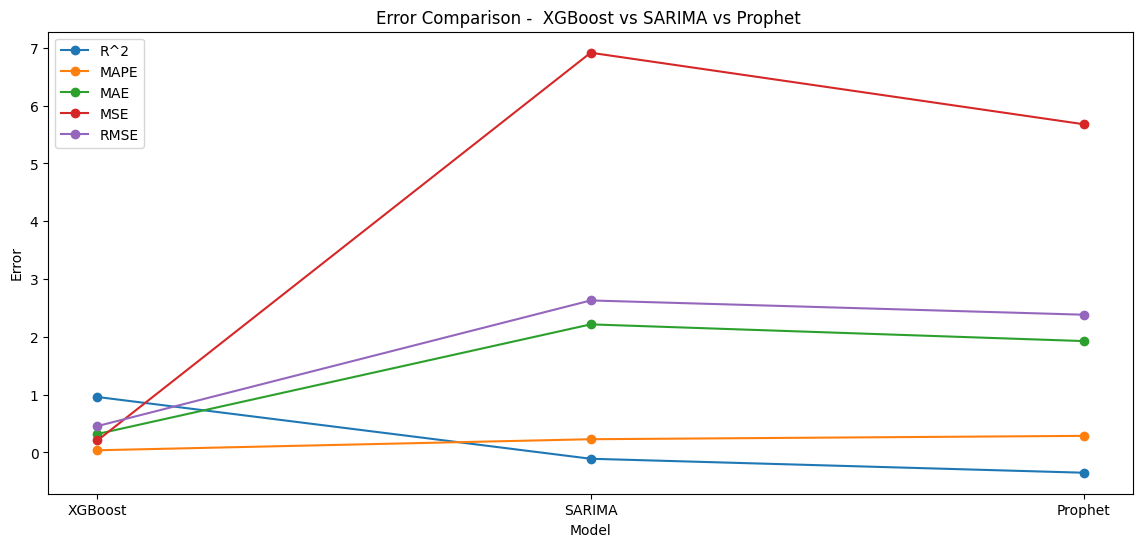

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(['XGBoost','SARIMA', 'Prophet' ], [xgb_r2, sarima_r2, prophet_r2, ], marker='o', label='R^2')
plt.plot(['XGBoost','SARIMA', 'Prophet' ], [xgb_mape, sarima_mape, prophet_mape], marker='o', label='MAPE')
plt.plot(['XGBoost','SARIMA', 'Prophet' ], [xgb_mae, prophet_mae, sarima_mae], marker='o', label='MAE')
plt.plot(['XGBoost','SARIMA', 'Prophet' ], [xgb_mse, prophet_mse, sarima_mse], marker='o', label='MSE')
plt.plot(['XGBoost','SARIMA', 'Prophet' ], [xgb_rmse, prophet_rmse, sarima_rmse], marker='o', label='RMSE')

plt.title('Error Comparison -  XGBoost vs SARIMA vs Prophet ')
plt.xlabel('Model')
plt.ylabel('Error')
plt.legend()
plt.show()

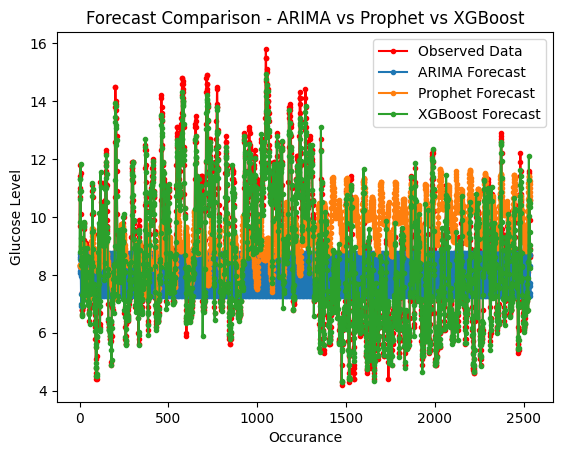

In [15]:
# Plot all forecasts in a single graph

#test_plot=test.reset_index(drop=True)
#test_plot=test_plot.set_index('Hours')

arima_forecast=sarima_forecast.reset_index(drop=True)
#arima_forecast_plot=arima_forecast_plot.set_index('Hours')

prophet_forecast=prophet_forecast.reset_index(drop=True)
#prophet_forecast_plot=prophet_forecast_plot.set_index('Hours')

#xgb_forecast=xgb_forecast.reset_index(drop=True)
#xgb_forecast_plot=xgb_forecast_plot.set_index('Hours')


#plt.figure(figsize=(15,5))
plt.plot(test['Glucose'],label='Observed Data', color='red', marker='o', linestyle='solid',markersize=3)
plt.plot(arima_forecast, label='ARIMA Forecast',marker='o', linestyle='solid',markersize=3)
plt.plot(prophet_forecast['yhat'], label='Prophet Forecast', marker='o',linestyle='solid',markersize=3)
plt.plot(xgb_forecast, label='XGBoost Forecast',marker='o', linestyle='solid',markersize=3)

plt.title('Forecast Comparison - ARIMA vs Prophet vs XGBoost')
plt.xlabel('Occurance')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()


ARIMA Forecasting Errors:
MAE: 1.9039272518221735
MSE: 6.179599224916648
RMSE: 2.4858799699335137


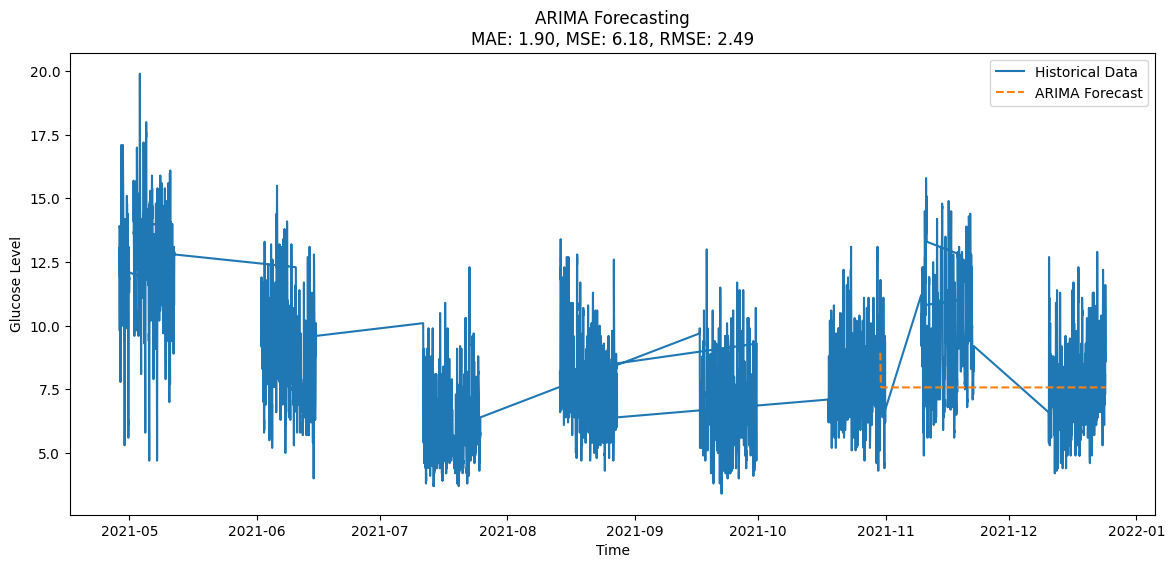


Prophet Forecasting Errors:
MAE: 2.2160348374859895
MSE: 6.916996129664893
RMSE: 2.6300182755381933


<Figure size 1400x600 with 0 Axes>

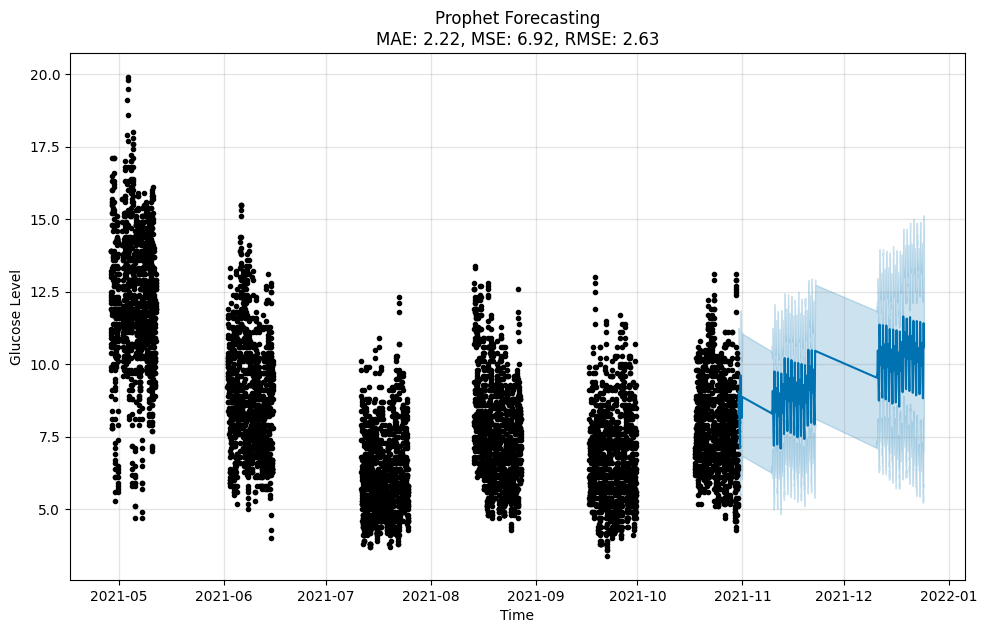


XGBoost Forecasting Errors:
MAE: 0.3527382359542246
MSE: 0.2462443154775374
RMSE: 0.49623010335683726


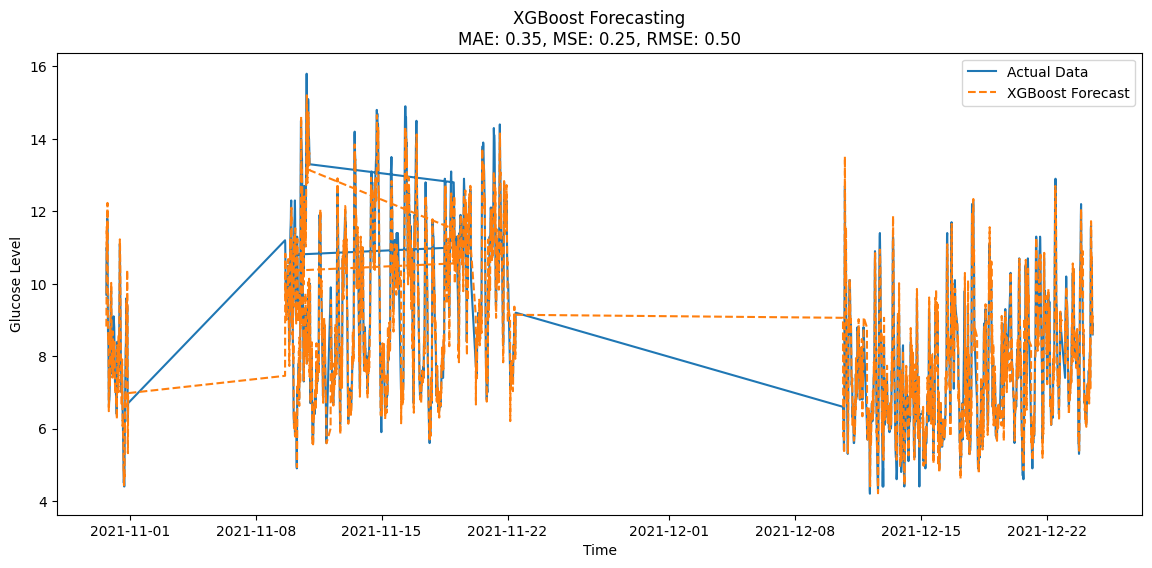

In [5]:
# ... (Previous code)

# Calculate ARIMA errors
arima_mae = mean_absolute_error(test['Glucose'], arima_forecast)
arima_mse = mean_squared_error(test['Glucose'], arima_forecast)
arima_rmse = np.sqrt(arima_mse)

# Print ARIMA errors
print('ARIMA Forecasting Errors:')
print('MAE:', arima_mae)
print('MSE:', arima_mse)
print('RMSE:', arima_rmse)

# Plot ARIMA results
plt.figure(figsize=(14, 6))
plt.plot(df['Time'], df['Glucose'], label='Historical Data')
plt.plot(test['Time'], arima_forecast, label='ARIMA Forecast', linestyle='dashed')
plt.title('ARIMA Forecasting\nMAE: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}'.format(arima_mae, arima_mse, arima_rmse))
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()

# ... (Repeat similar sections for Prophet and XGBoost)

# Print Prophet errors
print('\nProphet Forecasting Errors:')
print('MAE:', prophet_mae)
print('MSE:', prophet_mse)
print('RMSE:', prophet_rmse)

# Plot Prophet results
plt.figure(figsize=(14, 6))
prophet_model.plot(prophet_forecast, xlabel='Time', ylabel='Glucose Level')
plt.title('Prophet Forecasting\nMAE: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}'.format(prophet_mae, prophet_mse, prophet_rmse))
plt.show()

# ... (Repeat similar sections for XGBoost)

# Print XGBoost errors
print('\nXGBoost Forecasting Errors:')
print('MAE:', xgb_mae)
print('MSE:', xgb_mse)
print('RMSE:', xgb_rmse)

# Plot XGBoost results
plt.figure(figsize=(14, 6))
plt.plot(test['Time'], test['Glucose'], label='Actual Data')
plt.plot(test['Time'], xgb_forecast, label='XGBoost Forecast', linestyle='dashed')
plt.title('XGBoost Forecasting\nMAE: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}'.format(xgb_mae, xgb_mse, xgb_rmse))
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.legend()
plt.show()
